# Chemical Analysis
Chemical networks are complex systems where the interplay between many elements often means that small changes in one aspect of the network can greatly effect the outcome in unexpected ways. Nevertheless, there are cases where a simple chemical explanation can be found for some observed behaviour in the model outputs. This tutorial demonstrates how to use some of the functionality of the UCLCHEM library to analyse model outputs and discover these explanations.

We do recommend caution when following the approach laid out in this tutorial. There are many pitfalls which we will try to point out as we go. Ultimately, a comprehensive view of how important a reaction is to the outcome of your model requires detailed statistical calculations such as the use of [SHAP values](https://github.com/slundberg/shap) to assign meaningful scores to how much various reactions in a network contribute to a species' abundance. Therefore, care must be taken by the user to ensure that the conclusions they draw from a simpler approach are sound. Examples of papers doing this for UCLCHEM include:
- [Understanding molecular abundances in star-forming regions using interpretable machine learning Open Access](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526..404H/abstract) Heyl, J., Butterworth, J., & Viti, S. 2023, MNRAS, 526, 404
- [A statistical and machine learning approach to the study of astrochemistry](https://ui.adsabs.harvard.edu/abs/2023FaDi..245..569H/abstract) Heyl, J., Viti, S., & Vermariën, G. 2023, Faraday Discussions, 245,
569
- [Understanding molecular ratios in the carbon and oxygen poor outer Milky Way with interpretable machine learning](https://ui.adsabs.harvard.edu/abs/2025arXiv250508410V/abstract) Vermariën, G., Viti, S., Heyl, J., Fontani, F., 2025, A&A, 699, A18  

We'll use an example from work that was published in 2022 [Energizing Star Formation: The Cosmic-Ray Ionization Rate in NGC 253 Derived from ALCHEMI Measurements of H3O+ and SO](https://ui.adsabs.harvard.edu/abs/2022ApJ...931...89H/abstract) to demonstrate the use of the rates coming out of UCLCHEM and how it can be used to draw conclusions about the most important reactions in a network for a given species/behaviour.

In [17]:
import uclchem
from glob import glob
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## H3O+ and SO

In a piece of inference work in which we measured the cosmic ray ionization rate (CRIR) in NGC 253 [(Holdship et al. 2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220403668H/abstract). We found that both H3O+ and SO were sensitive to the ionization rate. Furthermore, since H3O+ was increased in abundance by increasing CRIR and SO was destroyed, their ratio was extremely sensitive to the rate. 

In the work, we present the plot below which shows how the equilibrium abundance of each species changes with the CRIR as well as the ratio. We plot this for a range of temperatures to show that this behaviour is not particularly sensitive to the gas temperature.


![crir_h3o_so_example](./assets/holdship_ngc253.png)

In a sense, this is all the information we need. A complex array of reactions all compete and contribute to produce the outcome of the model. Whatever they are, we see the abundance of these species are very sensitive to the CR over a wide range of temperature and density. However, we can only trust this conclusion as far as we trust the entire chemical network since we don't know what exactly causes this behaviour.

If we use the analysis function, we may find all of this is driven by a small handful of reactions. The benefit would then be that our trust in our conclusions only depends on how much we trust the rates of those specific reactions. If it is very important, we can evaluate those reactions and readers of our work can make the same decisions as information from experiment changes.

### 1. Generate Test Cases
Ideally, we should run a huge grid of models and find some rigorous way to evaluate how important each reaction is to the outcome of the model. However, if we run a small grid representative of different conditions then any simple chemical explanation will be evident if it exists. If it no simple explanation is appropriate, then the analysis module is not appropriate for our task and we could consider more complex approaches.

Let's run a simple grid with all possible combinations of the following:
- A low CRIR (zeta=1) and high CRIR (zeta=1e4)
- A typical cloud density (n=1e4) and high density (n=1e6)
- The lower temperature bound of NGC 253 CMZ (75 K)* and a high temperature (250 K) 
* The lower boundary is a bit lower, but the computational time of 50K models is a lot longer than 75K so we stick with a bit higher values for speed

and that will give us enough to work with for our analysis.

When we run the model and want to interact with the rates directly after running, UCLCHEM must be told to return it to the user. This 
can be done using both `return_dataframe=True` and `return_rates=True`. The model will then return the
physics (temperature, density etc), abundances and rates as a function of time.

In [2]:
temperatures = [100, 200]
densities = [1e4, 1e6]
zetas = [1, 1e4]

parameterSpace = np.asarray(np.meshgrid(temperatures, densities, zetas)).reshape(3, -1)
model_table = pd.DataFrame(parameterSpace.T, columns=["temperature", "density", "zeta"])
model_names = [f"model_{i}" for i in range(len(model_table))]
model_table.index = model_names
print(f"{model_table.shape[0]} models to run")


def run_model(row):
    # basic set of parameters we'll use for this grid.
    ParameterDictionary = {
        "baseAv": 10,  # UV shielded gas in our model
        "freefall": False,
        "finalTime": 1e6,
        "initialtemp": float(row["temperature"]),
        "initialdens": float(row["density"]),
        "zeta": float(row["zeta"]),
    }
    result = uclchem.model.cloud(
        param_dict=ParameterDictionary, return_dataframe=True, return_rates=True
    )
    return result


model_table


8 models to run


,temperature,density,zeta
model_0,100.0,10000.0,1.0
model_1,100.0,10000.0,10000.0
model_2,200.0,10000.0,1.0
model_3,200.0,10000.0,10000.0
model_4,100.0,1000000.0,1.0
model_5,100.0,1000000.0,10000.0
model_6,200.0,1000000.0,1.0
model_7,200.0,1000000.0,10000.0


In [3]:
# Each result contains: physics, abundances, rates, final_abundances and succesflag
results = Parallel(n_jobs=10, verbose=100)(
    delayed(run_model)(row) for idx, row in model_table.iterrows()
)
results = {k: v for k, v in zip(model_names, results)}

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done   2 out of   8 | elapsed:    4.8s remaining:   14.5s
[Parallel(n_jobs=10)]: Done   3 out of   8 | elapsed:    5.7s remaining:    9.4s
[Parallel(n_jobs=10)]: Done   4 out of   8 | elapsed:    6.5s remaining:    6.5s
[Parallel(n_jobs=10)]: Done   5 out of   8 | elapsed:   15.3s remaining:    9.2s
[Parallel(n_jobs=10)]: Done   6 out of   8 | elapsed:   18.5s remaining:    6.2s
[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed:  1.3min finished


### 2. Analyze the rates
UCLCHEM will compute and save the rates of each of your reactions during the simulation. It is then returned to the user to be inspected. 


For example, if we care about H3O+ and find that it is created by $H_2O$ + $H^+$, then UCLCHEM is called to get $k$, the rate of that reaction and then analysis calculates
$$
\dot{Y(H_3O^+)} = k Y(H_2O) Y(H^+) n_H
$$

where $\dot{Y(H_3O^+)}$ is the rate of change of the $H_3O+$ abundance due to the reaction. The $\dot{Y}$ s of each reaction involving the $H_3O^+$ are then compared to see which reactions contribute the most to the destruction and formation of $H_3O+$.

Our plan then is to do this for the low zeta case and the high zeta case. Hopefully, we'll see the same reactions are most important to the abundance of $H_3O^+$ and SO at all densities and tempertures. If we don't find that that's the case, then the chemistry is these species is fairly complex and perhaps trying to present a simple cause for the CRIR dependence is not a good idea.

So, let's analyse the outputs!

#### 2.1 $H_3O^+$

Let's inspect the reaction file of H3O+ for a high temperature, low density and low radiation field model (model 2)

<Axes: xlabel='Time'>

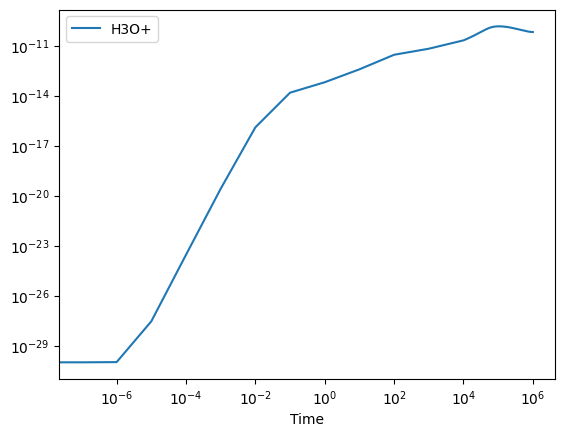

In [4]:
# Retrieve the outputs from the grid:
physics, abundances, rates, final_abundances, successflag = results["model_2"]

# Add everything together into one large dataframe
super_df = pd.concat((physics, abundances, rates), axis=1)

# Plot the evolution of H3O+:
super_df.plot("Time", "H3O+", logx=True, logy=True)

Above, we can see that the H3O+ is being formed effectively. If we then want to better understand which reactions are responsible for this formation process, we can easily obtain the production and struction routes using:



In [5]:
from uclchem.analysis import get_production_and_destruction

production, destruction = get_production_and_destruction("H3O+", rates)

production.tail()

,CH+ + H2O -> H3O+ + C,CH4 + H2O+ -> H3O+ + CH3,CH4 + OH+ -> H3O+ + CH2,CH4+ + H2O -> H3O+ + CH3,CH5+ + H2O -> H3O+ + CH4,H2 + H2O+ -> H3O+ + H,H2+ + H2O -> H3O+ + H,H2O + C2H2+ -> C2H + H3O+,H2O + H2CO+ -> HCO + H3O+,H2O + H2CL+ -> HCL + H3O+,...,H2O+ + HCO -> CO + H3O+,H3+ + CH3CHO -> H3O+ + C2H4,H3+ + H2O -> H3O+ + H2,H3+ + HCOOH -> H3O+ + CO + H2,NH + H2O+ -> H3O+ + N,NH+ + H2O -> H3O+ + N,NH2+ + H2O -> H3O+ + NH,O + CH5+ -> H3O+ + CH2,OH + H2O+ -> H3O+ + O,OH+ + H2O -> H3O+ + O
189,7.103520e-10,1.400000e-09,1.310000e-09,3.184337e-09,4.531556e-09,9.700000e-10,4.164133e-09,2.694439e-10,3.184337e-09,2.449490e-09,...,3.429286e-10,1.273735e-09,7.225995e-09,2.204541e-09,8.695689e-10,1.285982e-09,3.380296e-09,2.200000e-10,8.450740e-10,1.592168e-09
190,7.103520e-10,1.400000e-09,1.310000e-09,3.184337e-09,4.531556e-09,9.700000e-10,4.164133e-09,2.694439e-10,3.184337e-09,2.449490e-09,...,3.429286e-10,1.273735e-09,7.225995e-09,2.204541e-09,8.695689e-10,1.285982e-09,3.380296e-09,2.200000e-10,8.450740e-10,1.592168e-09
191,7.103520e-10,1.400000e-09,1.310000e-09,3.184337e-09,4.531556e-09,9.700000e-10,4.164133e-09,2.694439e-10,3.184337e-09,2.449490e-09,...,3.429286e-10,1.273735e-09,7.225995e-09,2.204541e-09,8.695689e-10,1.285982e-09,3.380296e-09,2.200000e-10,8.450740e-10,1.592168e-09
192,7.103520e-10,1.400000e-09,1.310000e-09,3.184337e-09,4.531556e-09,9.700000e-10,4.164133e-09,2.694439e-10,3.184337e-09,2.449490e-09,...,3.429286e-10,1.273735e-09,7.225995e-09,2.204541e-09,8.695689e-10,1.285982e-09,3.380296e-09,2.200000e-10,8.450740e-10,1.592168e-09
193,7.103520e-10,1.400000e-09,1.310000e-09,3.184337e-09,4.531556e-09,9.700000e-10,4.164133e-09,2.694439e-10,3.184337e-09,2.449490e-09,...,3.429286e-10,1.273735e-09,7.225995e-09,2.204541e-09,8.695689e-10,1.285982e-09,3.380296e-09,2.200000e-10,8.450740e-10,1.592168e-09


<Axes: >

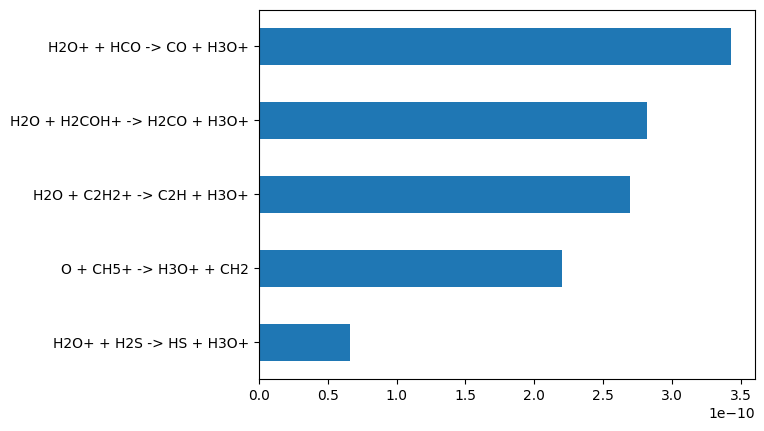

In [13]:
production.iloc[-1].sort_values(ascending=True)[:5].plot.barh()

We can then also effectively convert from rates constants k, to the actual RHS
elements that contribute to each reaction; We can then get fluxes rather than rates:


In [14]:
from uclchem.analysis import rates_to_dy_and_flux
from uclchem.utils import get_reaction_network

network = get_reaction_network()
dy, flux = rates_to_dy_and_flux(physics, abundances, rates, network=network)

We can then inspect the RHS of the differential equation per reaction. This informs us that the only relevant term is actually the destruction of the molecule via its reaction with HCS and H2S. Explaining the small decrease at 1 million years.

<Axes: title={'center': 'destruction'}>

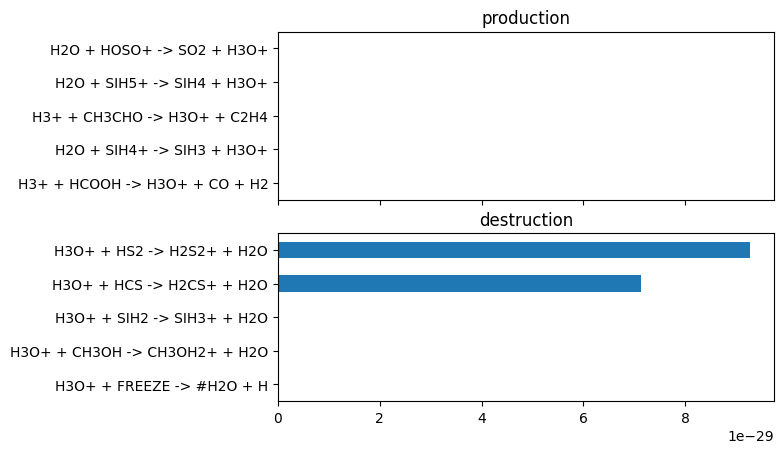

In [20]:
production, destruction = get_production_and_destruction("H3O+", flux)
fig, ax = plt.subplots(2, 1, sharex=True)
production.iloc[-1].sort_values(ascending=True)[:5].plot.barh(
    ax=ax[0], title="production"
)
destruction.iloc[-1].sort_values(ascending=True)[:5].plot.barh(
    ax=ax[1], title="destruction"
)

# UPDATE to UMIST22
As of 11-10-2024, we use UMIST22 for the notebook, so we need to repeat this analysis. Some dominant formation and destruction pathways are no longer present for in UMIST22. The rest of the notebook is thus no longer up to-date!



 
We can then delve into specifically the low temperature, low density, low zeta case:

```
New Important Reactions At: 7.90e+05 years
Formation = 1.92e-18 from:
H2 + H2O+ -> H3O+ + H : 78.49%
H2O + HCO+ -> CO + H3O+ : 17.68%
H3+ + H2O -> H3O+ + H2 : 3.40%

Destruction = -1.92e-18 from:
H3O+ + E- -> OH + H + H : 65.43%
H3O+ + E- -> H2O + H : 15.21%
H3O+ + E- -> OH + H2 : 11.52%
H3O+ + H2S -> H3S+ + H2O : 5.17%
H3O+ + E- -> O + H2 + H : 1.20%
H3O+ + HCN -> HCNH+ + H2O : 0.33%
H3O+ + SIO -> SIOH+ + H2O : 0.33%
```

What this shows is the reactions that cause 99.9% of the formation and 99.9% of the destruction of $H_3O^+$ at a time step. The total rate of formation and destruction in units of $s^{-1}$ is  given as well the percentage of the total that each reaction contributes. 

What we need to find is a pattern in these reactions which holds across time and across different densities and temperatures. It actually turns out that the reactions printed above are the dominate formation and destruction routes of $H_3O^+$ for all parameters for all times. For example, at high temperature, high density and high zeta, we get:

```
New Important Reactions At: 1.00e+04 years
Formation = 2.03e-14 from:
H2 + H2O+ -> H3O+ + H : 95.47%
H3+ + H2O -> H3O+ + H2 : 3.14%
H2O + HCO+ -> CO + H3O+ : 1.05%

Destruction = -2.03e-14 from:
H3O+ + E- -> OH + H + H : 69.82%
H3O+ + E- -> H2O + H : 16.23%
H3O+ + E- -> OH + H2 : 12.29%
H3O+ + E- -> O + H2 + H : 1.28%
```
The sole difference being that the formation rate is much higher. Since equilibrium is reached, the destruction rate is also higher and so we need to use the fact we know the $H_3O^+$ abundance increases with CRIR to infer that the destruction rate is only faster because there is more $H_3O^+$ to destroy.

However, there are some problems here! Why does $H_2$ + $H_2O^+$ become so efficient at high CRIR? We know the rate of a two body reaction does not depend on CRIR ([see the chemistry docs](/docs/gas)) so it must be that $H_2O^+$ is increasing in abundance. We can run analysis on $H_2O^+$ to see what is driving that. In fact, as we report in the paper, following this thread we find that a chain of hydrogenations starting from $OH^+$ is the overall route of $H_3O^+$ formation and that this chain starts with small ions that are primarly formed through cosmic ray reactions. *It will very often be the case that analysing one species requires you to run analysis on another.*

#### 2.2 SO

With a strong explanation for $H_3O^+$, we can now look at SO. We start by running analysis again and then by looking at the reactions as before.

Again, let's start by looking at the low temperature, high density, low zeta case:

```
New Important Reactions At: 1.31e+04 years
Formation = 3.67e-22 from:
#SO + THERM -> SO : 68.11%
HSO+ + E- -> SO + H : 21.04%
#SO + DEUVCR -> SO : 9.87%

Destruction = -3.78e-22 from:
SO + FREEZE -> #SO : 78.04%
HCO+ + SO -> HSO+ + CO : 20.97%
```

An interesting point here is that equilbrium is reached at around $1.31 \times 10^4$ yr in this model. Since `analysis()` only prints a time step when the most important reactions are different to the last one, this time step is the last output from the analysis. We can see that we broadly reach an equilibrium between thermal desorption and freeze out of SO, with some formation and destruction via ions. 

This doesn't hold up at lower densities or higher temperatures, looking at the high temperature, low density, low zeta case, we see a second pattern of reactions:

```
New Important Reactions At: 9.50e+05 years
Formation = 1.05e-20 from:
O2 + S -> SO + O : 98.10%
O + NS -> SO + N : 1.48%

Destruction = -1.02e-20 from:
C + SO -> CS + O : 39.10%
C + SO -> S + CO : 39.10%
C+ + SO -> SO+ + C : 4.33%
C+ + SO -> CS+ + O : 4.33%
C+ + SO -> S+ + CO : 4.33%
C+ + SO -> S + CO+ : 4.33%
N + SO -> S + NO : 3.46%
H+ + SO -> SO+ + H : 0.28%
```
However, it's not so complex. All the low zeta outputs show one of these two sets of reactions. Essentially, higher temperatures are opening up gas phase reaction routes which form and destroy SO. These new routes are not particularly quick with a total rate of change of $10^{-20} s^{-1}$. Note that quite a lot of these are due to reactions with ions.

Finally, we look at the high zeta cases and find that no matter the temperature or density, we see the same reactions:

```
New Important Reactions At: 1.81e+04 years
Formation = 5.64e-17 from:
O2 + S -> SO + O : 85.30%
HSO+ + E- -> SO + H : 13.19%
O + NS -> SO + N : 1.19%

Destruction = -5.64e-17 from:
H+ + SO -> SO+ + H : 13.16%
C+ + SO -> SO+ + C : 10.52%
C+ + SO -> CS+ + O : 10.52%
C+ + SO -> S+ + CO : 10.52%
C+ + SO -> S + CO+ : 10.52%
H3+ + SO -> HSO+ + H2 : 9.86%
C + SO -> CS + O : 8.90%
C + SO -> S + CO : 8.90%
SO + CRPHOT -> S + O : 4.11%
SO + CRPHOT -> SO+ + E- : 4.11%
HCO+ + SO -> HSO+ + CO : 3.20%
HE+ + SO -> S+ + O + HE : 1.93%
HE+ + SO -> S + O+ + HE : 1.93%
N + SO -> S + NO : 0.87%
```

Ions take over the destruction of SO when the CRIR is high and these reactions are proceeding about 1000 times faster than the low zeta rates. This makes sense as increasing the CRIR will greatly increase the abundances of these simple ionic species.

All in all, we can conclude that a range of gas phase reactions control the abundance of SO at low zeta but once the CRIR is high, destruction via ions dominates the SO chemistry leading to the decreasing abundance that we see.

## Summary Notes

In this notebook, we've run some representative models to look at why the SO and $H_3O^+$ abundances seem to so heavily depend on the CRIR. We find that a chain of very efficient reactions starting with simple ions comprise the primary formation route of $H_3O^+$ so that the total production of this species depends entirely on the abundance of those ions. With high CRIR, those ions become very abundant and we get a lot of $H_3O^+$ formation.

SO is complex at first glance since the formation routes vary by parameter. However, looking at the destruction routes we can see that it's simply that SO can be easily destroyed by simple ions and, again, these are very abundant in gas exposed to a high CRIR.

An interesting note about SO is that we could potentially say that destruction via C$^+$ is the dominant destruction route. However, we would caution users to be careful with that kind of statement. Reactions with H$^+$, HE$^+$ and other also destroy SO. It could be that if we turned off the C$^+$ reactions, the SO chemistry would be unchanged as other ions take up the slack. Therefore, unless a single reaction is clearly dominant (as in $H_3O^+$ formation), it is best to test the importance of a reaction by removing it before concluding it is the single most important reaction.

## Considerations

`uclchem.analysis.analysis()` looks at a snapshot of the gas and calculates the instantaneous rate of change of important reactions. However, over the course of a time step, abundances change and reactions rise and fall in importance. More importantly, complex interplay between reactions can contribute to an outcome. This is ultimately a simple, first order look at what is happening in the network but in many cases, a deeper view will be required.

If you struggle to find an explanation that fits all time steps in your outputs and is true across a range of parameters, then it is best not to report simple conclusions about the chemistry and to look for other ways to understand the network.